In [1]:
from IPython.display import display, HTML, Audio
display(HTML("<style>.container {width: 100%; important! }</style>"))
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import time
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from scipy.io import wavfile

In [2]:
fname_1 = 'original_sound/borya_Karim.wav'
fname_2 = 'original_sound/motivation_Aynur.wav'
fs, audio_in_1 = wavfile.read(fname_1)
fs, audio_in_2 = wavfile.read(fname_2)

In [3]:
if audio_in_1.shape[0] > audio_in_2.shape[0]:
    audio_in_2 = np.concatenate((np.zeros(audio_in_1.shape[0] - audio_in_2.shape[0]), audio_in_2))
else:
    audio_in_1 = np.concatenate((np.zeros(audio_in_2.shape[0] - audio_in_1.shape[0]), audio_in_1))

In [4]:
unmixed = np.vstack([audio_in_1, audio_in_2])
unmixed = unmixed - np.expand_dims(unmixed.mean(1), axis=1)
unmixed = unmixed/np.expand_dims(np.std(unmixed, axis=1), axis=1)

In [5]:
unmixed.mean(1)

array([-1.55080729e-17, -4.69309352e-18])

In [6]:
np.std(unmixed, axis=1)

array([1., 1.])

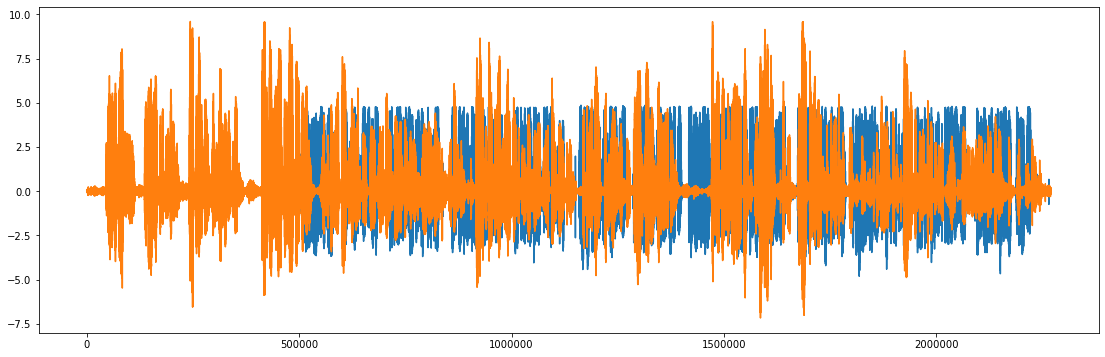

In [7]:
plt.figure(figsize=(19,6))
plt.plot(unmixed[0])
plt.plot(unmixed[1])

In [8]:
mixture_matrix = np.array([[2.1, 1], [1.2, 1.7]])
fs, mixed = wavfile.read('mixed/borya_Karim.wav_motivation_Aynur.wav_absorb=0.0.wav')
mixed = mixed.T

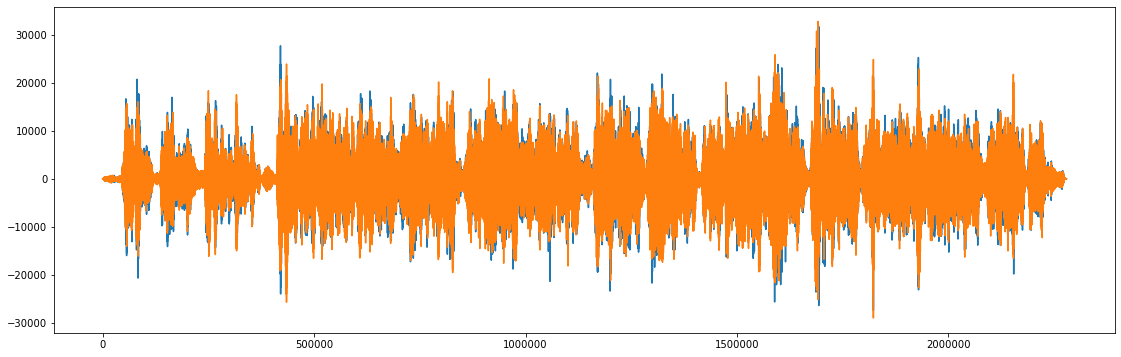

In [9]:
plt.figure(figsize=(19,6))
plt.plot(mixed[0])
plt.plot(mixed[1])

## Preprocessing

In [10]:
def center(signal):
    return signal - np.expand_dims(signal.mean(axis=1), axis=1)

def white(signal):
    matrix = np.cov(signal)
    w, E = np.linalg.eig(matrix)
    D = np.sqrt(np.linalg.pinv(np.diag(w)))
    M = E @ D @ E.T
    return M @ signal

def preprocess(signal):
    return white(center(signal))

In [11]:
print(np.linalg.inv(mixture_matrix))

[[ 0.71729958 -0.42194093]
 [-0.50632911  0.88607595]]


In [12]:
preprocessed = preprocess(mixed)

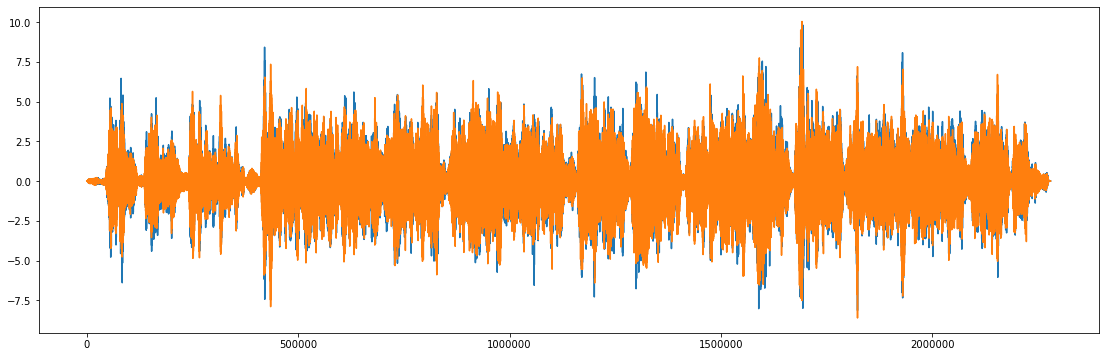

In [13]:
plt.figure(figsize=(19,6))
plt.plot(preprocessed[0])
plt.plot(preprocessed[1])

In [14]:
def derivG2(u):
    return u*np.exp(-(1/2)*u**2)

In [15]:
def deriv_deriv_G(u):
    return (1 - u**2)*np.exp(-(1/2)*u**2)

In [16]:
def converge_criterium(prev_w, curr_w, eps=0.01):
    if np.abs(prev_w.T@curr_w) < (1 - eps):
        return True
    else:
        return False
    

In [17]:
deriv_deriv_G(5)

-8.94396761298881e-05

In [18]:
curr_w = np.random.rand(mixed.shape[0])
prev_w = np.random.rand(mixed.shape[0])
curr_w = curr_w / np.linalg.norm(curr_w)
prev_w = prev_w / np.linalg.norm(prev_w)

In [19]:
converge_criterium(prev_w, curr_w)

True

In [20]:
# prev_v = curr_w.copy()


In [21]:
curr_w.T@mixed

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
(mixed @ derivG2(curr_w.T @ mixed)) / mixed.shape[1]

array([-0.03052586,  0.02958893])

In [23]:
curr_w = (mixed @ derivG2(curr_w.T @ mixed)) / mixed.shape[1] - curr_w*(deriv_deriv_G(curr_w.T @ mixed)).mean()
curr_w = curr_w / np.linalg.norm(curr_w)

In [43]:
eps = 10**(-9)

In [44]:
while converge_criterium(prev_w, curr_w, eps):
    prev_w = curr_w.copy()
    curr_w = (((preprocessed @ derivG2(curr_w.T @ preprocessed)) / preprocessed.shape[1]) 
              - curr_w*(deriv_deriv_G(curr_w.T @ preprocessed)).mean())
    curr_w = curr_w / np.linalg.norm(curr_w)

In [36]:
curr_w

array([ 0.7269739 , -0.68666509])

In [27]:
np.linalg.inv(mixture_matrix)

array([[ 0.71729958, -0.42194093],
       [-0.50632911,  0.88607595]])

In [45]:
np.abs(prev_w.T@curr_w)

0.9999999990513184

In [46]:
res = curr_w.T @ preprocessed
# res = np.linalg.inv(mixture_matrix)[:,0].T@preprocessed
res = res/np.abs(res).max()
res = (res*32767).astype(np.int16)
wavfile.write('one_ch_unmix_bor_mot_model_res.wav', rate=fs, data=res)

In [48]:
Audio("one_ch_unmix_bor_mot_model_res.wav")

In [30]:
# res = curr_w.T@preprocessed
# res = np.linalg.inv(mixture_matrix)[:,0].T@preprocessed
# res = res/np.abs(res).max()
# res = (res*32767).astype(np.int16)
# wavfile.write('once_ch_unmix_bor_mot_inv.wav', rate=fs, data=res)

In [31]:
# res.shape

In [32]:
# wavfile.write('one_ch_unmix_bor_mot_model_res.wav', rate=fs, data=res)